In [15]:
import sys
import os
#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))) # for scripts
project_root = '/Users/emilykruger/Documents/GitHub/CSH-Internship'
functions_dir = os.path.join(project_root, 'src/functions')
model_dir = os.path.join(project_root, 'src/DAEGC')
sys.path.append(project_root) #for local notebook
sys.path.append(functions_dir) #for local notebook

import pandas as pd
import numpy as np
from daegc_helpers import create_adj_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from src.DAEGC.GAT import GAT
from torchview import draw_graph

In [2]:
# show all columns in pd df
pd.set_option('display.max_columns', None)

# Load Datasets

In [3]:
# load aggregated dataset to analyse features
features = pd.read_csv('../results/post-aggregation/author_full.csv.gzip', compression='gzip')
features.columns

/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_54196/2208293635.py:2: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv('../results/post-aggregation/author_full.csv.gzip', compression='gzip')


Index(['author', 'noun_count', 'verb_count', 'adj_count', 'positive_sentiment',
       'negative_sentiment', 'neutral_sentiment', 'channel_messages',
       'group_messages', 'sent_count', 'word_count', 'avg_sent_length',
       'avg_word_length', 'exclamation_count', 'question_count', 'emoji_count',
       'flesch_reading_ease', 'liwc_I', 'liwc_We', 'liwc_You', 'liwc_Other',
       'liwc_Affect', 'final_message', 'final_message_string', 'own_message',
       'forwarded_message', 'total_message_count', 'was_forwarded',
       'own_message_count', 'forwarded_message_count', 'action_quotient',
       'sentiment_quotient', 'avg_flesch_reading_ease_class', 'toxicity'],
      dtype='object')

In [4]:
# load "raw" dataset to analyse adjacency matrix
data = pd.read_csv('../data/samples/messages_sample_full.csv.gzip', compression='gzip')

# Descriptive Stats for Features

In [5]:
features.describe()

,noun_count,verb_count,adj_count,positive_sentiment,negative_sentiment,neutral_sentiment,channel_messages,group_messages,sent_count,word_count,avg_sent_length,avg_word_length,exclamation_count,question_count,emoji_count,flesch_reading_ease,liwc_I,liwc_We,liwc_You,liwc_Other,liwc_Affect,own_message,forwarded_message,total_message_count,was_forwarded,own_message_count,forwarded_message_count,action_quotient,sentiment_quotient,toxicity
count,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,12675.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,16885.000000,16885.000000,16885.000000,16885.000000,16885.000000,16885.000000,8560.000000,9468.000000,9991.000000
mean,51.615735,32.916908,10.434516,0.200097,0.369568,0.359687,0.000462,0.999538,2.434866,17.717202,5.533415,4.510139,0.214030,0.201662,0.418265,71.453204,0.021662,0.005413,0.010528,0.022547,0.060082,0.779688,0.119759,22.032810,0.068108,14.248860,4.463133,3.633670,0.424459,0.123155
std,466.686233,207.916228,83.752429,0.300154,0.361259,0.367137,0.021479,0.021479,2.469537,31.573321,7.559799,2.043270,0.587346,0.515147,1.047216,16.903249,0.042595,0.018391,0.027432,0.036620,0.097460,0.346956,0.266679,144.946595,3.144563,83.807806,40.859031,3.332185,0.710016,0.141751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001264
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.500000,2.785119,4.000000,0.000000,0.000000,0.000000,63.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,1.000000,0.000000,1.000000,0.000000,1.666667,0.000000,0.018849
50%,5.000000,3.000000,1.000000,0.000000,0.333333,0.272727,0.000000,1.000000,2.000000,10.282857,4.926786,4.841192,0.000000,0.000000,0.130435,74.103846,0.000000,0.000000,0.000000,0.010000,0.035800,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000,3.000000,0.166667,0.056264
75%,21.000000,14.000000,4.000000,0.300000,0.600000,0.565217,0.000000,1.000000,3.000000,19.800000,7.167014,5.423193,0.166667,0.250000,0.600000,82.441500,0.029636,0.003122,0.010120,0.032028,0.076396,1.000000,0.037037,9.000000,0.000000,7.000000,1.000000,4.625000,0.588235,0.190293
max,38325.000000,9496.000000,4719.000000,1.000000,1.000000,1.000000,1.000000,1.000000,75.500000,756.000000,756.000000,93.000000,16.000000,22.000000,35.000000,100.000000,1.000000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,8221.000000,343.000000,4065.000000,1821.000000,51.000000,13.000000,0.960691


# Correlation Analysis of Features

## All Features

In [6]:
corr_df = features.drop(['author','final_message', 'final_message_string', 'avg_flesch_reading_ease_class'], axis=1)
corr_df = corr_df.fillna(corr_df.mean())
corr = corr_df.corr()

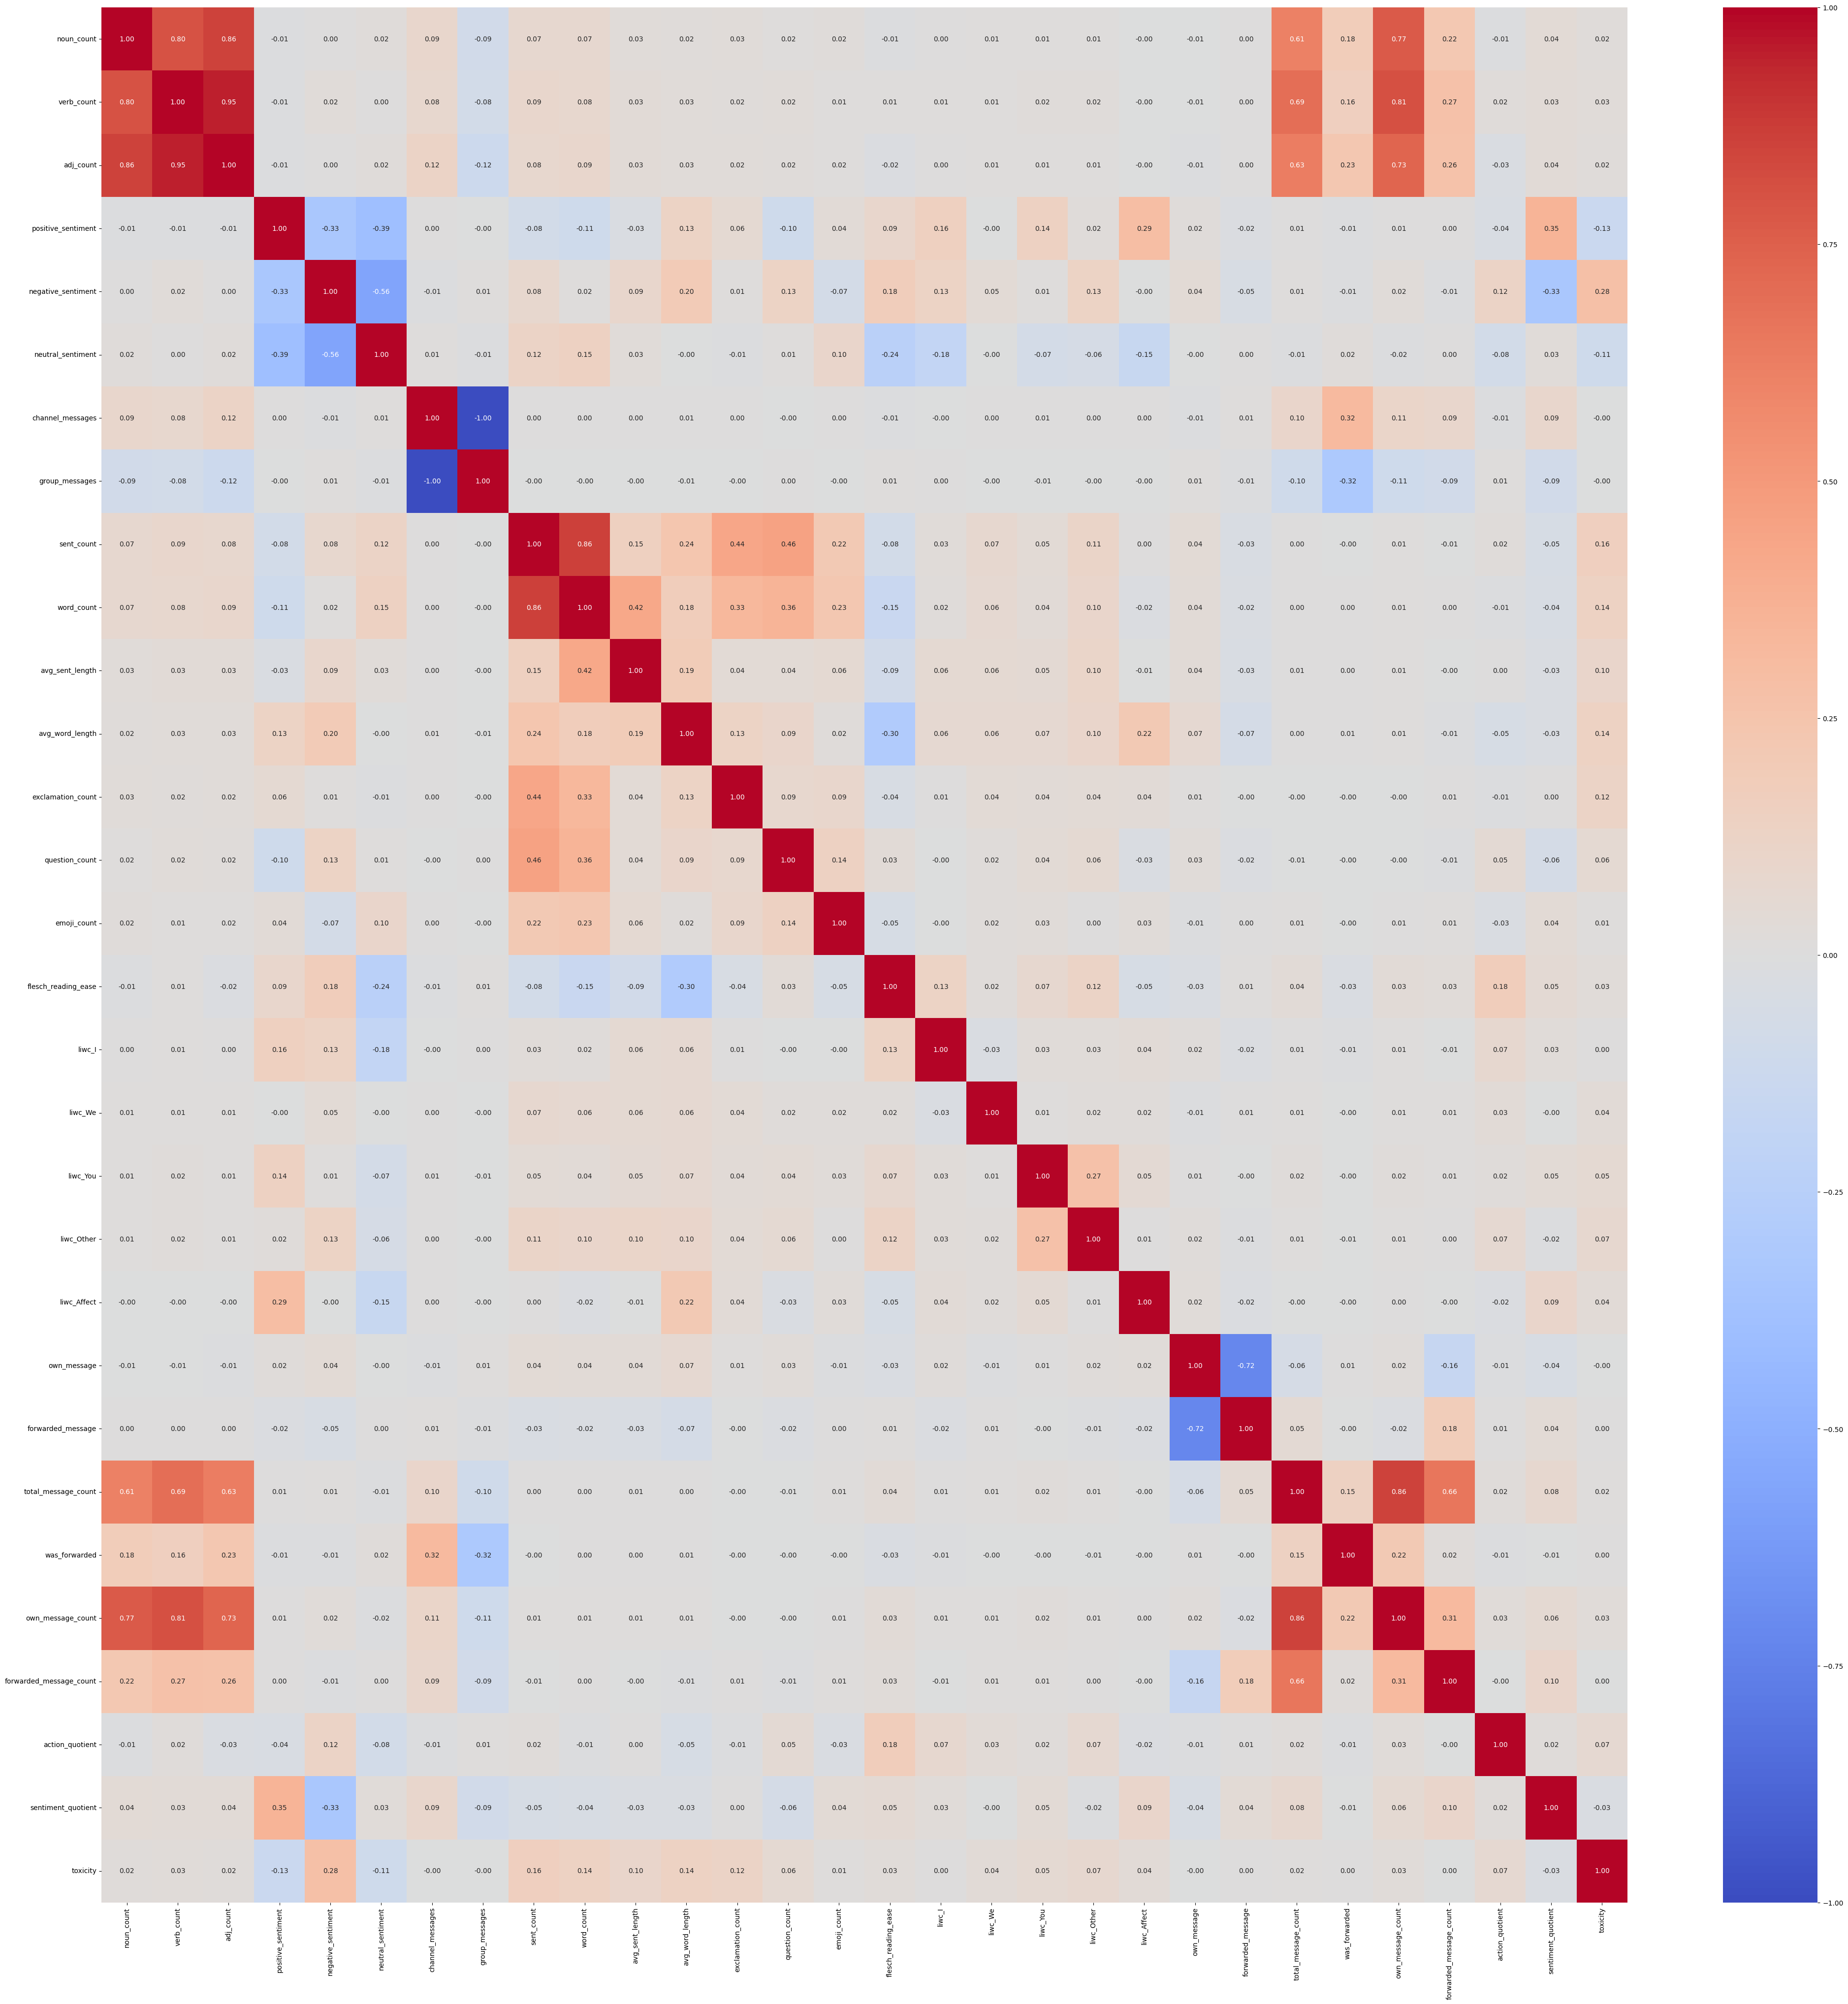

In [7]:
plt.figure(figsize=(50,50))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Highly Correlated Features

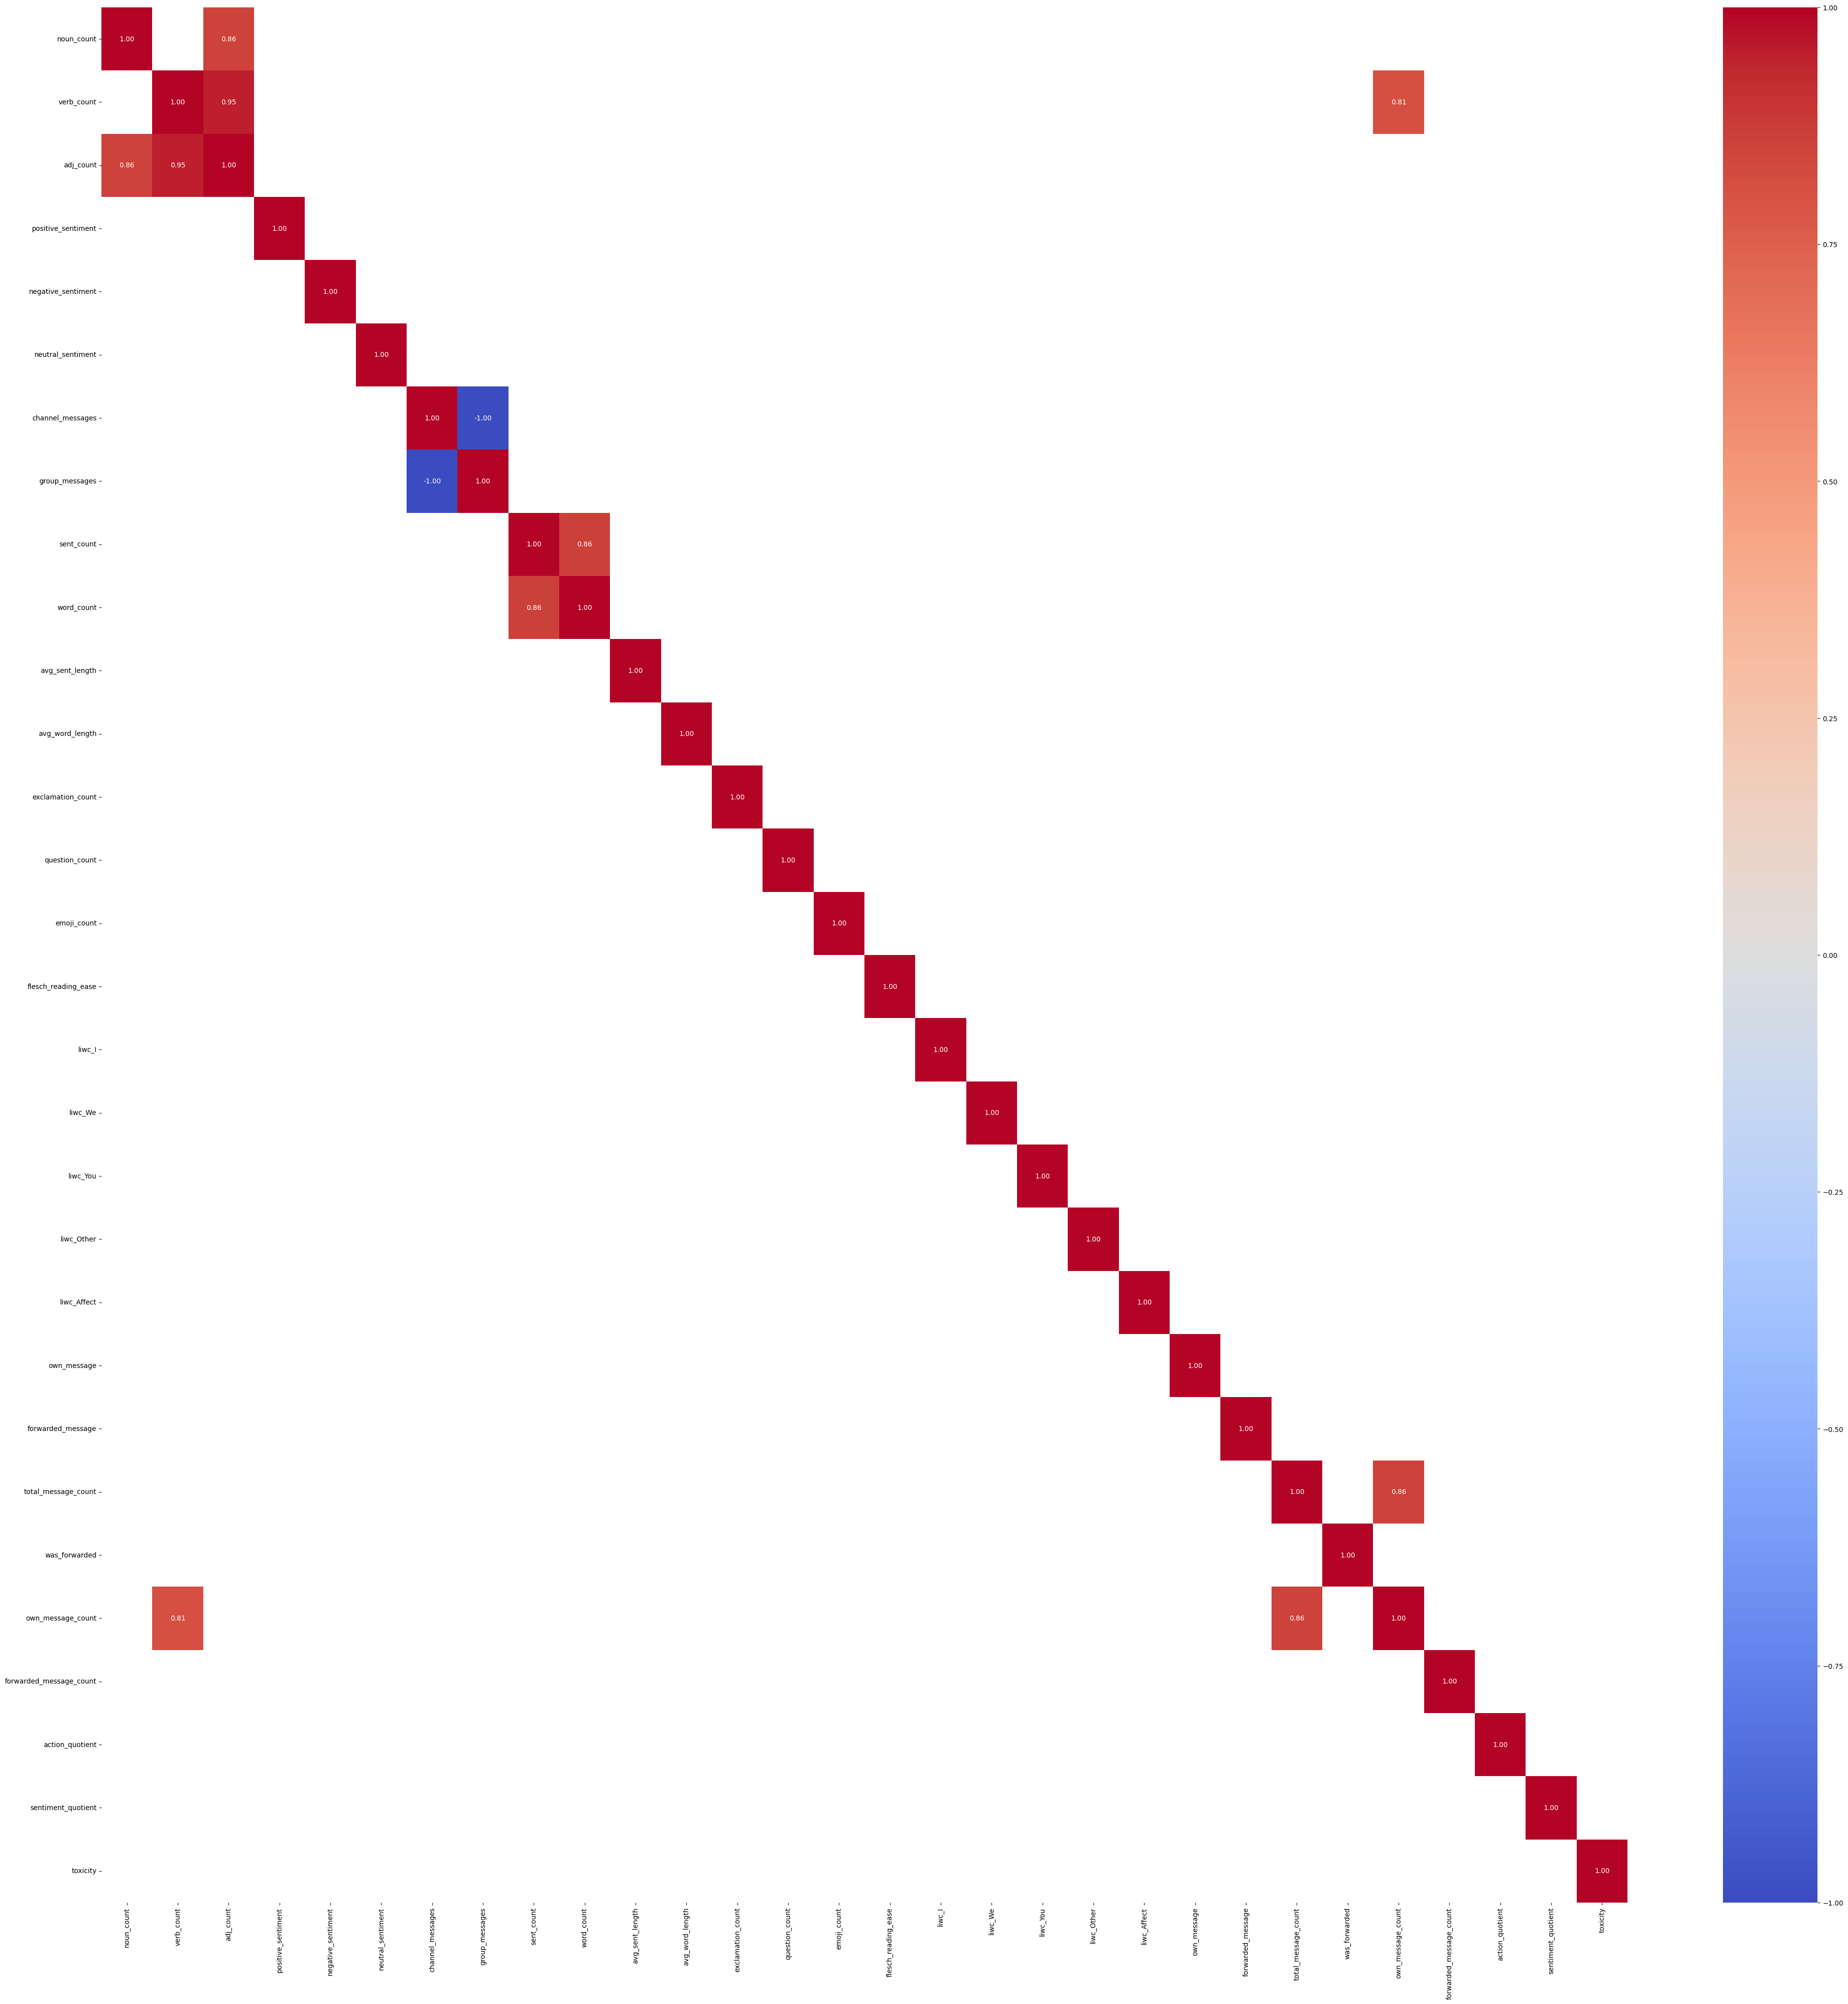

In [8]:
# in matrix, only show corrs over .8
high_corr = corr[abs(corr)>=.8]
plt.figure(figsize=(50,50))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [9]:
#print out pairs of highly correlated features incl their correlation
high_corr = high_corr.unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr!=1]
high_corr = high_corr.reset_index()
high_corr.columns = ['feature1', 'feature2', 'correlation']
high_corr = high_corr[high_corr['correlation'].notnull()]
high_corr[['feature1', 'feature2']] = np.sort(high_corr[['feature1', 'feature2']], axis=1)
high_corr = high_corr.drop_duplicates(subset=['feature1', 'feature2'])
high_corr

,feature1,feature2,correlation
0,adj_count,verb_count,0.946990
2,sent_count,word_count,0.864686
4,own_message_count,total_message_count,0.857767
6,adj_count,noun_count,0.855350
8,own_message_count,verb_count,0.808949
10,channel_messages,group_messages,-1.000000


# Descriptive Stats for Adjacency Matrix

In [10]:
adj, adj_norm = create_adj_matrix(data)

Authors: 16885
Adjacency tensor shape: torch.Size([16885, 16885])
Normalized adjacency tensor shape: torch.Size([16885, 16885])


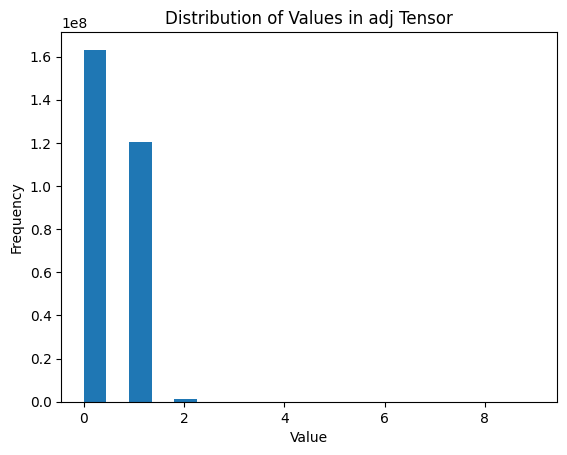

In [ ]:
#summary statistics
mean=adj.mean().item() #mean of tensor values
std_dev=adj.std().item() #standard deviation of tensor values
min_val=adj.min().item() #minimum value in tensor
max_val=adj.max().item() #maximum value in tensor

#histogram
plt.hist(adj.flatten().cpu().numpy(),bins=20) #flatten tensor and plot histogram with 20 bins
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Weights in Adjacency Matrix')
plt.show()

In [12]:
print(mean, std_dev, min_val, max_val)

0.4336593449115753 0.5089782476425171 0.0 9.0


In [13]:
# MSE with marix that only predicts 0
zero_matrix = torch.zeros(adj.shape)
mse = torch.nn.MSELoss()
mse(adj, zero_matrix)

tensor(0.4471)

# Visualization of Model